In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.metrics import accuracy_score

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [3]:
# create Ticket_type from Ticket to be used as numerical feature
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,124
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,137
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,148


In [4]:
# Create new feature family size
train['Family_size'] = train['SibSp'] + train['Parch'] + 1 # number of siblings + number of parents + oneself
test['Family_size'] = test['SibSp'] + test['Parch'] + 1

# Create new feature isAlone
train['isAlone'] = train['Family_size'].apply(lambda x: 0 if x != 1 else 1)
test['isAlone'] = test['Family_size'].apply(lambda x: 0 if x != 1 else 1)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names, taken from imoore and adapted to fit the rest of my notebook
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

# Fill NULL values in age with random values close to the avg age
avg_age = pd.concat([train, test], axis=0)['Age'].mean()
age_std = pd.concat([train, test], axis=0)['Age'].std()
count_age_null_train = train['Age'].isnull().sum()
count_age_null_test = test['Age'].isnull().sum()
age_train_random_list = np.random.randint(avg_age - age_std, avg_age + age_std, size=count_age_null_train)
age_test_random_list = np.random.randint(avg_age - age_std, avg_age + age_std, size=count_age_null_test)
train['Age'][np.isnan(train['Age'])] = age_train_random_list
test['Age'][np.isnan(test['Age'])] = age_test_random_list
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

# Fill all NULLS in Embarked collumn
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

# Fill all NULLS in Cabin
train['Cabin'] = train['Cabin'].fillna('N')
test['Cabin'] = test['Cabin'].fillna('N')


train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Family_size,isAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,N,S,124,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,137,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,N,S,148,1,1,Miss


In [5]:
# Find fare values to create equal sized groups in training set for mapping
# fare = train['Fare'].sort_values()
# np.array_split(fare, 4)
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [6]:
# Mapping Sex
train['Sex'] = train['Sex'].map({'female': 0, 'male': 1}).astype(int)
test['Sex'] = test['Sex'].map({'female': 0, 'male': 1}).astype(int)

# mapping Title
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train['Title'] = train['Title'].map(title_mapping)
train['Title'] = train['Title'].fillna(0)
test['Title'] = test['Title'].map(title_mapping)
test['Title'] = test['Title'].fillna(0)

# Mapping Embarked
train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

# Mapping fare
train.loc[train['Fare'] <= 7.9, 'Fare'] = 0
train.loc[(train['Fare'] > 7.9) & (train['Fare'] <= 14.455), 'Fare'] = 1
train.loc[(train['Fare'] > 14.455) & (train['Fare'] <= 31), 'Fare'] = 2
train.loc[train['Fare'] > 31, 'Fare'] = 3

test.loc[test['Fare'] <= 7.9, 'Fare'] = 0
test.loc[(test['Fare'] > 7.9) & (test['Fare'] <= 14.455), 'Fare'] = 1
test.loc[(test['Fare'] > 14.455) & (test['Fare'] <= 31), 'Fare'] = 2
test.loc[test['Fare'] > 31, 'Fare'] = 3

train['Fare'] = train['Fare'].astype(int)
test['Fare'] = test['Fare'].fillna(3)
test['Fare'] = test['Fare'].astype(int)

# Mapping Age
train.loc[train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age'] = 3
train.loc[train['Age'] > 64, 'Age'] = 4

test.loc[test['Age'] <= 16, 'Age'] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), 'Age'] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), 'Age'] = 2
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), 'Age'] = 3
test.loc[test['Age'] > 64, 'Age'] = 4

In [7]:
# Feature selection

train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type,Family_size,isAlone,Title
0,0,3,1,1,1,0,0,0,124,2,0,1
1,1,1,0,2,1,0,3,1,137,2,0,3
2,1,3,0,1,0,0,1,0,148,1,1,2
3,1,1,0,2,1,0,3,0,3,2,0,3
4,0,3,1,2,0,0,1,0,97,1,1,1


In [8]:
test.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type,Family_size,isAlone,Title
0,3,1,2,0,0,0,2,58,1,1,1
1,3,0,2,1,0,0,0,71,2,0,3
2,2,1,3,0,0,1,2,32,1,1,1
3,3,1,1,0,0,1,0,55,1,1,1
4,3,0,1,1,1,1,0,54,3,0,3


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

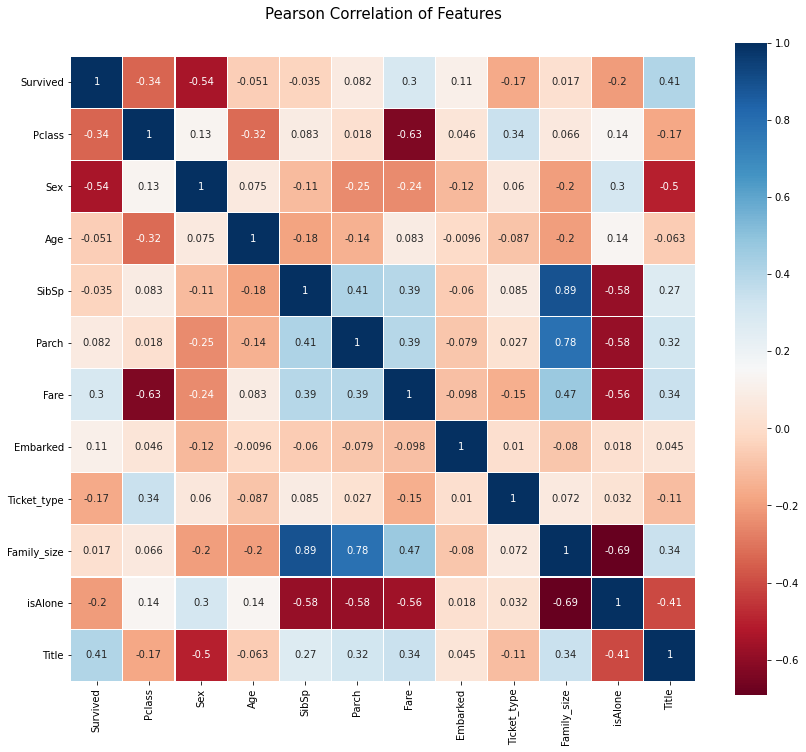

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [10]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train_xgbc = train.values
x_test_xgbc = test.values
x_train = train
x_test = test

In [11]:
xgbc = xgb.XGBClassifier(
 # learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 5,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_xgbc, y_train)
xgb_train_predictions = xgbc.predict(x_train_xgbc)
xgb_predictions = xgbc.predict(x_test_xgbc)
# check accuracy on training data
# accuracy_score(y_train, xgb_train_predictions)

[20:06:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
# make predictions using the RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=1)
rfc.fit(x_train, y_train)
rfc_train_predictions = rfc.predict(x_train)
rfc_predictions = rfc.predict(x_test)
# check accuracy on training data
# accuracy_score(y_train, rfc_train_predictions)

In [13]:
# make predictions using the AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=200, learning_rate=1)
abc.fit(x_train, y_train)
abc_train_predictions = abc.predict(x_train)
abc_predictions = abc.predict(x_test)
# check accuracy on training data
# accuracy_score(y_train, abc_train_predictions)

In [14]:
# make predictions using the GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, max_depth=4, random_state=0)
gbc.fit(x_train, y_train)
gbc_train_predictions = gbc.predict(x_train)
gbc_predictions = gbc.predict(x_test)
# check accuracy on training data
# accuracy_score(y_train, gbc_train_predictions)

In [15]:
# combining the classifiers to achieve an ensemble prediciton
# assigning weights to the classifiers according to their accuracy on the test set rfc > gbc > xgb > abc
xgb_w, rfc_w, abc_w, gbc_w = 0.25, 0.30, 0.20, 0.25

# creating the ensemble prediction
df_xgb = pd.DataFrame({'PassengerId': PassengerId, 'Survived': xgb_predictions})
df_rfc = pd.DataFrame({'PassengerId': PassengerId, 'Survived': rfc_predictions})
df_abc = pd.DataFrame({'PassengerId': PassengerId, 'Survived': abc_predictions})
df_gbc = pd.DataFrame({'PassengerId': PassengerId, 'Survived': gbc_predictions})

df_ensemble = df_xgb.copy()
k = 'Survived'
df_ensemble[k] =  xgb_w*df_xgb[k] + rfc_w*df_rfc[k] + abc_w*df_abc[k] + gbc_w*df_gbc[k]
df_ensemble[k] = df_ensemble[k].apply(lambda f: 1 if f>=0.5 else 0)

df_ensemble.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [16]:
df_ensemble.to_csv('df_ensemble_prediction.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
